Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Bilal Siddiqi"
COLLABORATORS = ""

---


# CS210 - Lab 02: File Processing with Python

<h3>Introduction</h3>

<p>
  This lab introduces you to <strong>file processing in Python</strong>, a core skill for working with real-world data.
  The goal is to practice opening, reading, writing, and validating different file formats while learning safe and
  efficient techniques. You’ll start with simple text and CSV files, move on to JSON and encoding issues, and finish
  with strategies for handling large files. Along the way, you’ll practice error handling, use the
  <code>pathlib</code> library for cross-platform paths, and see how to organize outputs cleanly.
</p>

<p><strong>By the end of the lab, you should feel confident about:</strong></p>
<ul>
  <li>Navigating file systems and working with relative paths.</li>
  <li>Reading and writing text, CSV, and JSON files safely.</li>
  <li>Handling encoding problems and malformed data gracefully.</li>
  <li>Processing large files without running out of memory.</li>
</ul>

<p>
  These skills are foundational for <strong>data science</strong>, <strong>software development</strong>, and
  <strong>system programming</strong>—where almost every project starts with processing data from files.
</p>

**Tip:** Prefer `pathlib` for paths. Always use `with open(...) as f:` when reading/writing files.

### Use of AI
You may complete this assignment w/o using any AI. If you do, you must <b>use cGPT</b> when <b>appropriate</b>. The goal is to learn how to use AI to understand key concepts. They will be tested in exams and quizzes. DO NOT include any cGPT generated content w/o first understanding what they mean. You will be asked to submit a text file of prompts used to complete the assignment.
<br>
<b>Use of any other AI's including chatGPT, Gemini, etc are prohibited</b> <br>
As you complete Tasks, and if you used cGPT, update the lab02_report.txt as you go. Be sure to save the files.


### Saving the files
Be sure to SAVE all files frequently to make sure you will not lose your work

## Task 1 - Understanding various file management tools
Run the code below and <b>explain what each line does as a comment</b>. You can use cGPT, but rewrite comments in your own words

In [4]:
from pathlib import Path
from collections import Counter
import csv, json, sys, os, shutil

BASE = Path.cwd()            # Creates a var that stores the current working directory.
DATA = BASE / "data" # From the current working directory, a Path object with the "data" subdirectory is accessed and assigned to DATA.                   
OUT = BASE / "output"        # From the current working directory, a Path object with the "output" subdirectory is accessed and assigned to OUT. 
OUT.mkdir(parents=True, exist_ok=True)      # Creates a directory. Exist_ok verifies that if the directory already exists, there won't be any duplication errors. Parent creates the neccessary parent directories needed.
print("Working directory:", BASE)           # Prints out the current working directory.
print("Data exists?", DATA.exists())        # Returns true/false depending on if the directory in the DATA Path object exists.
print("Output exists?", OUT.exists())       # Returns true/false depending on if the directory in the OUT Path object. exists.
print("CSV files:", list(DATA.glob("*.csv")))  # Returns a list of .csv files found in the directory stored in the DATA Path object.


Working directory: /home/bms283/cs210f25/Lab 02 - File Processing
Data exists? True
Output exists? True
CSV files: [PosixPath('/home/bms283/cs210f25/Lab 02 - File Processing/data/broken.csv'), PosixPath('/home/bms283/cs210f25/Lab 02 - File Processing/data/movies.csv')]



## Task 2: Paths & Safety

- Use `pathlib` + `glob` to list all CSV files under `data/` and print file sizes and last modified times.
- Confirm you understand **relative vs absolute** paths.
- Your Sample output may look like this. Confirm by inspecting files manually
  <pre>
      broken.csv            193 bytes  modified: 2025-09-18 08:20:58.487581
      movies.csv           7856 bytes  modified: 2025-09-18 08:20:58.584581
  </pre>


In [5]:
from datetime import datetime
import csv, os
from pathlib import Path

BASE = Path.cwd()
try:
    DATA = BASE / "data"
    if DATA.exists():
        for x in list(DATA.glob("*csv")):
            stat = os.stat(x)
            print(x.name + "            " + str(stat.st_size) + " bytes  modified: " + str(datetime.fromtimestamp(stat.st_mtime)))
except FileNotFoundError:
    print("File not found.")
except PermissionError:
    print("Proper permissions not granted.")
    


broken.csv            193 bytes  modified: 2025-09-23 11:01:21.181149
movies.csv            7856 bytes  modified: 2025-09-23 11:01:21.182148



## Task 3: Read & Summarize a Log 
Log files are a big part of text data processing. Log files contain important information that can be used to generate various services.<br>
Read `data/access.log` **line-by-line**. For each line, parse:
- timestamp
- method
- path
- status code

Compute request counts by status code and write a summary to `output/status_summary.txt` with aligned columns. A sample output file may look like ...

<pre> 
Status    Count
----------------
200         255
201          71
204          92
    ....
</pre>


### Activities: Implement streaming read, parse fields, count status codes, write summary

In [13]:
import re

log_path = DATA / "access.log"
status_summary = OUT/ "status_summary.txt"
status_counts = Counter()
timestamp_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2})\s*\]'
method_pattern = r'\"([A-Z]+)'
path_pattern = r'\"[A-Z]+\s+([^\"\s]+)'
status_code_pattern = r'HTTP/\d\.\d\"\s+(\d{3})'

try:
    with log_path.open("r", encoding="utf-8") as f:
        for line in f:
            timestamp_match = re.search(timestamp_pattern, line)
            method_match = re.search(method_pattern, line)
            path_match = re.search(path_pattern, line)
            status_code_match = re.search(status_code_pattern, line)
            
            if status_code_match:
                code = status_code_match.group(1)
                status_counts[code] += 1
except FileNotFoundError:
    print("File not found.")
except PermissionError:
    print("Proper permissions not granted.")
except UnicodeDecodeError:
    print("Characters cannot be encoded.")

try:
    with status_summary.open("w", encoding="utf-8") as f2:
        f2.write("Status    Count\n")
        f2.write("----------------\n")
        for code in sorted(status_counts, key=int):
            f2.write(f"{code:<8}{status_counts[code]}\n")
except PermissionError:
    print("Proper permissions not granted.")




## Task 4: CSV File Processing

Read `data/movies.csv` using the `csv` module:
- Strip whitespace, coerce numeric fields (`year`, `rating`, `votes`).
- Decide how to handle missing/invalid rows (skip or default).<br>
<b>Compute:</b>
- Top 10 movies by rating (break ties with `votes`).
- Average rating per `year`.

Write outputs to:
- `output/top10_movies.csv`
- `output/avg_rating_by_year.csv`


### Sample Outputs

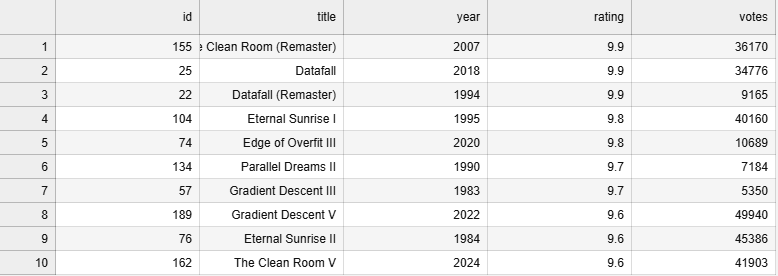

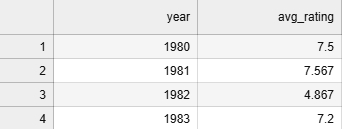

In [7]:
import csv
import re

movies_in = DATA / "movies.csv"
top10_out = OUT / "top10_movies.csv"
avg_by_year_out = OUT / "avg_rating_by_year.csv"
valid_records = []
years = set()
average_per_year = {}

if movies_in.exists():
    try:
        with open(movies_in, 'r', encoding = "utf-8") as movies:
            reader = csv.DictReader(movies)
            for row in reader:
                valid = True
                for key,value in row.items():
                    if value == None or value =='' or ((key == 'year' or key == 'rating' or key == 'votes') and re.search(r'[a-zA-Z]', value)):
                        valid = False      
                        
                if valid == True:
                    row['year'] = int(row['year'])
                    row['rating'] = float(row['rating'])
                    row['votes'] = int(row['votes'])
                    valid_records.append(row)
    except FileNotFoundError:
        print("File not found.")
    except PermissionError:
        print("Proper permissions not granted.")
    except UnicodeDecodeError:
        print("Characters cannot be encoded.")
    except csv.Error:
        print("CSV file not found.")
       

try:
    rating = sorted(valid_records, key= lambda row: (-row['rating'], -row['votes']))
    with open(top10_out, 'w') as top10:
        header = rating[0].keys()
        writer = csv.DictWriter(top10, fieldnames=header)
        writer.writeheader()
        writer.writerows(rating[:10])
except PermissionError:
    print("Proper permissions not granted.")

for x in valid_records:
    years.add(x['year'])

for x in years:
    average_per_year[x] ={
        "ratings": [],
        "average": 0
    }

for record in valid_records:
    year = record['year']
    rating = record['rating']
    average_per_year[year]["ratings"].append(rating)

for y in average_per_year:
    average_per_year[y]["average"] = sum(average_per_year[y]["ratings"]) / len(average_per_year[y]["ratings"])

try:
    with open(avg_by_year_out, 'w', encoding = "utf-8") as avg_out:
        writer = csv.writer(avg_out)
        writer.writerow(["year", "avg_rating"])
        for y in average_per_year:
            writer.writerow([y, average_per_year[y]["average"]])
except PermissionError:
    print("Proper permissions not granted.")


    

    

    



## Task 5: JSON Read/Write + Validation 

Load `data/products.json`. Validate required keys: `id`, `name`, `price`.
- Valid → compute `price_with_tax` (+8%) and keep minimal fields
- Invalid → collect as-is

Write two new json files to output folder:
- `output/products_clean.json`
- `output/products_invalid.json`


### Products_clean_format<br>
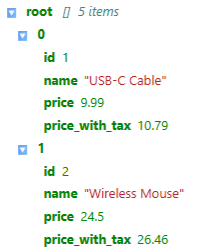 <br>

### Products_invalid_format<br>
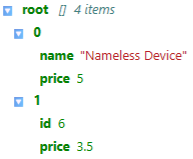

In [8]:
import json


products = DATA / "products.json"
valid_file = OUT / "products_clean.json"
invalid_file = OUT / "products_invalid.json"
invalid = []
valid = []

if products.exists():
    try:
        with open(products, 'r', encoding = "utf-8") as read_product:
            product_data = json.load(read_product)
            for x in range(len(product_data)): 
                if len(product_data[x]) < 4: 
                   invalid.append(product_data[x]) 
                else: 
                    product_data[x]["price_with_tax"] = float(product_data[x]["price"]) * 1.08 
                    valid.append(product_data[x])
                    
    except FileNotFoundError:
        print("File not found.")
    except PermissionError:
        print("Proper permissions not granted.")
    except json.JSONDecodeError:
        print("No valid JSON file has been provided.")
    except UnicodeDecodeError:
        print("Characters cannot be encoded.")

try:
    with open(valid_file, "w", encoding="utf-8") as valid_files:
        json.dump(valid, valid_files)

    with open(invalid_file, "w", encoding="utf-8") as invalid_files:
         json.dump(invalid, invalid_files)
except PermissionError:
    print("Proper permissions not granted.")






## Task 6: Encodings & Newlines 

Read `data/notes_utf8.txt` with `encoding='utf-8'`. Show a few characters including emojis.
Re-write as ASCII using `errors='ignore'` or `'replace'` to `output/notes_ascii.txt`.
### Sample Output format
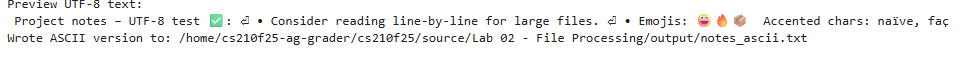 <br>

### notes_ascii format
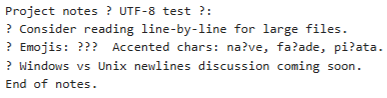


In [9]:
UTF8 = DATA / "notes_utf8.txt"
OUTASCII = OUT / "notes_ascii.txt"
if UTF8.exists():
    try:
        with open(UTF8, "r", encoding="utf-8", errors='ignore') as ascii_format:
            ignore = ascii_format.read()
        
        with open(OUTASCII, "w", encoding="utf-8", errors='ignore') as ascii_write:
            ascii_write.write(ignore)
    
    except FileNotFoundError:
        print("File not found.")
    except PermissionError:
        print("Proper permissions not granted.")






## Task 7: Large File Patterns 

Show a streaming approach (generator or chunked read) to count lines or words in `access.log` without loading the file.
Optionally compare to a naive `.read()`.<br>

### Sample output
<pre>
    Streaming line count: 1210
    Naive read length (chars): 120259
</pre>


In [10]:
log_path = DATA / "access.log"

line = 0
chars = 0

if log_path.exists():
    try:
        with log_path.open("r", encoding="utf-8") as log:
            while True:
                chunk = log.read(4096)
                if not chunk:
                    break
                line = line + chunk.count("\n")
                chars = chars + len(chunk)
        
            if not (chunk.endswith("\n")) and chars > 0:
                line = line + 1
    except FileNotFoundError:
        print("File not found.")
    except PermissionError:
        print("Proper permissions not granted.")
    except UnicodeDecodeError:
        print("Characters cannot be encoded.")

    
print("Streaming line count: " + str(line))
print("Naive read length (chars): " + str(chars))

            
        


       




Streaming line count: 1210
Naive read length (chars): 120259



## Task 8 : Robustness & Troubleshooting
Go back and check if you have done the following. Ask <b>cGPT</b> if you need assistance with anything <br>
- Handle `FileNotFoundError`, `PermissionError`, `UnicodeDecodeError`, `csv.Error`.
- Use `Path.exists()` and `Path.mkdir(parents=True, exist_ok=True)`.
- Validate CSV headers before processing.
### Prompt Log
- Write your cGPT prompts (if you used cGPT) and other thoughts on what you learned by doing this lab to `lab02_report.txt`.



## Your Deliverables

Ensure the following files exist under `output/`:
- `status_summary.txt`
- `top10_movies.csv`
- `avg_rating_by_year.csv`
- `products_clean.json`
- `products_invalid.json`
- `notes_ascii.txt`

Add a short `lab02_report.txt` describing your approach and any edge cases you handled. Submit the lab by the due date to codebench.
